In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from itertools import product

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment, random_py_environment, random_tf_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common

from tf_agents.networks import encoding_network


from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.networks.utils import BatchSquash
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer, episodic_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.utils import common as common_utils
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec

import collections

import gin
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
from tf_agents.agents import tf_agent
from tf_agents.policies import boltzmann_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import q_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.utils import composite
from tf_agents.utils import eager_utils
from tf_agents.utils import nest_utils
from tf_agents.utils import training as training_lib
from tf_agents.utils import value_ops
from tf_agents.networks import actor_distribution_network
from tf_agents.agents.reinforce import reinforce_agent




import matplotlib.pyplot as plt

import tensorflow as tf

tf.compat.v1.enable_v2_behavior()

In [6]:
class CarRentalEnv(py_environment.PyEnvironment):
    def __init__(self, locations=2, max_cars=15, max_days=100, max_move=5):
        self.locations = locations
        self.max_cars = max_cars
        self.max_days = max_days

        self._action_spec = array_spec.BoundedArraySpec(shape=(),
                                                        dtype=np.int32,
                                                        minimum = 0,
                                                        maximum = 10,
                                                        name='action')

        self._observation_spec = array_spec.BoundedArraySpec(shape=(locations,),
                                                             dtype=np.int32,
                                                             minimum=np.zeros(locations, dtype=np.int32),
                                                             maximum=np.ones(locations, dtype=np.int32)*max_cars,
                                                             name='observation')

        self._state = np.zeros(locations, dtype=np.int32)
        self._episode_ended = False
        self._num_days = 0
        
        self.total_rented = [0, 0]
        self.rental_rate = [3, 4]
        self.return_rate = [3, 2]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state[0] = np.random.randint(0, self.max_cars)
        self._state[1] = self.max_cars - self._state[0]
        self.total_rented = [0, 0]
        self._episode_ended = False
        self._num_days = 0
        return ts.restart(np.array(self._state, dtype=np.int32))

    def _step(self, action):

        if self._episode_ended:
            return self.reset()

        reward = self.move(action)

        self._num_days += 1

        if self.game_over():
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.int32), reward)
        else:
            return ts.transition(
                np.array(self._state, dtype=np.int32), reward=reward, discount=0.9)

    def calc_all_rewards(self):
        '''
        Reward of a morning state.
        '''
        for i, queue in enumerate(self.location_queues):
            for ini_num_car in range(self.max_cars + 1):
                queue.reset_ini_num_pkt(ini_num_car)
                probs, reward = queue.run_multiple_unit_slots()
                self.expected_rewards[i][ini_num_car] = reward


    def total_cars(self, start_cars, total_rented, rental_rate, return_rate):
        rented = np.random.poisson(rental_rate)

        if rented > start_cars:
            rented = start_cars
        else:
            pass
        total_rented += rented

        returned = np.random.poisson(return_rate)

        if returned > total_rented:
            returned = total_rented

        total_rented -= returned
        final_cars = start_cars - rented + returned
        return final_cars, rented, total_rented

    
    def move(self, action):
        """
        """
        # Update the state at end of the day
        reward = 0
        for i in range(self.locations):
            self._state[i], rented, self.total_rented[i] = self.total_cars(self._state[i],
                                                                           self.total_rented[i],
                                                                           self.rental_rate[i],
                                                                           self.return_rate[i])
            reward += rented*10

        if action>5:
            self._state[0] += action-5
            self._state[1] -= action-5
            reward -= 2*(action-5)
        else:
            self._state[0] -= action
            self._state[1] += action
            reward -= 2*(action)
        self._state = np.clip(self._state, a_min = 0, a_max = self.max_cars)
        return reward

    def game_over(self):
        return self._num_days > self.max_days

In [7]:
locations = 2

env1 = CarRentalEnv(locations)
utils.validate_py_environment(env1, episodes=2)
train_env = tf_py_environment.TFPyEnvironment(env1)

env2 = CarRentalEnv(locations)
utils.validate_py_environment(env2, episodes=2)
eval_env = tf_py_environment.TFPyEnvironment(env2)

In [8]:
time_step = train_env.reset()
    
for i in range(20):
    print("Current state: ", time_step.observation.numpy(), "Current reward:", time_step.reward)
    action = np.random.randint(0, 11)
    print("Action: ", action)
    time_step = train_env.step(action)

Current state:  [[ 1 14]] Current reward: tf.Tensor([0.], shape=(1,), dtype=float32)
Action:  5
Current state:  [[ 0 15]] Current reward: tf.Tensor([50.], shape=(1,), dtype=float32)
Action:  8
Current state:  [[3 8]] Current reward: tf.Tensor([44.], shape=(1,), dtype=float32)
Action:  8
Current state:  [[4 2]] Current reward: tf.Tensor([74.], shape=(1,), dtype=float32)
Action:  3
Current state:  [[1 4]] Current reward: tf.Tensor([14.], shape=(1,), dtype=float32)
Action:  3
Current state:  [[0 8]] Current reward: tf.Tensor([24.], shape=(1,), dtype=float32)
Action:  10
Current state:  [[5 1]] Current reward: tf.Tensor([50.], shape=(1,), dtype=float32)
Action:  7
Current state:  [[4 0]] Current reward: tf.Tensor([46.], shape=(1,), dtype=float32)
Action:  0
Current state:  [[3 1]] Current reward: tf.Tensor([20.], shape=(1,), dtype=float32)
Action:  10
Current state:  [[12  0]] Current reward: tf.Tensor([0.], shape=(1,), dtype=float32)
Action:  3
Current state:  [[9 4]] Current reward: tf.T

In [9]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 128  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [11]:
train_step_counter = tf.compat.v2.Variable(0)
fc_layer_params = (20, 20)
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [12]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [13]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, num_eval_episodes)

4152.4

In [14]:

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [15]:

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(128, 2), observation=(128, 2, 2), action=(128, 2), policy_info=(), next_step_type=(128, 2), reward=(128, 2), discount=(128, 2)), BufferInfo(ids=(128, 2), probabilities=(128,))), types: (Trajectory(step_type=tf.int32, observation=tf.int32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [16]:
iterator = iter(dataset)

print(iterator)

In [17]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 1030.2835693359375
step = 400: loss = 686.690673828125
step = 600: loss = 2790.5126953125
step = 800: loss = 1553.9183349609375
step = 1000: loss = 1926.68994140625
step = 1000: Average Return = 3189.199951171875
step = 1200: loss = 1126.546630859375
step = 1400: loss = 878.4148559570312
step = 1600: loss = 1978.81298828125
step = 1800: loss = 1672.1680908203125
step = 2000: loss = 1538.7518310546875
step = 2000: Average Return = 3425.60009765625
step = 2200: loss = 1699.5654296875
step = 2400: loss = 2414.43603515625
step = 2600: loss = 2578.261962890625
step = 2800: loss = 642.92138671875
step = 3000: loss = 1787.59033203125
step = 3000: Average Return = 3046.199951171875
step = 3200: loss = 1911.8980712890625
step = 3400: loss = 979.294677734375
step = 3600: loss = 469.83892822265625
step = 3800: loss = 1761.9146728515625
step = 4000: loss = 944.4429931640625
step = 4000: Average Return = 3433.0
step = 4200: loss = 946.4193725585938
step = 4400: loss = 287.1792602

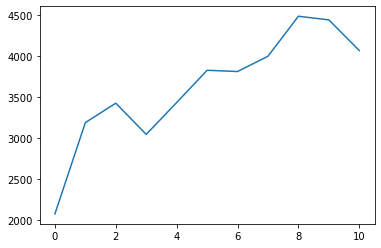

In [18]:
plt.plot(returns)

In [19]:
time_step = train_env.reset()
print(time_step.observation)

for i in range(10):
    
    print("State:", time_step.observation)
    action_step = agent.policy.action(time_step)
    print("Action:", action_step.action)
    time_step = train_env.step(action_step.action)

tf.Tensor([[9 6]], shape=(1, 2), dtype=int32)
State: tf.Tensor([[9 6]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([0], shape=(1,), dtype=int32)
State: tf.Tensor([[5 1]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[4 2]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([0], shape=(1,), dtype=int32)
State: tf.Tensor([[6 0]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[3 1]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([0], shape=(1,), dtype=int32)
State: tf.Tensor([[7 1]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[6 1]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[5 2]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([0], shape=(1,), dtype=int32)
State: tf.Tensor([[5 0]], shape=(1, 2), dtype=int32)
Action: tf.Tensor([1], shape=(1,), dtype=int32)
State: tf.Tensor([[4 3]], shape=(1, 2), dtype

(<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[4, 5]], dtype=int32)>,)

In [26]:
from itertools import product

time_step = train_env.reset()
max_num_car = 15

policy_matrix = np.zeros((max_num_car+1, max_num_car+1))

for i, j in product(range(max_num_car+1), range(max_num_car+1)):
    state = tf.constant(np.array([[i, j]]), dtype=tf.int32)
    policy_output = agent.policy.action(ts.TimeStep(time_step.step_type, reward=time_step.reward,
                                 discount=time_step.discount,
                                 observation=state))
    action = policy_output.action.numpy()[0]
    
    if action > 5:
        action -= 5
    
    policy_matrix[i,j] = action

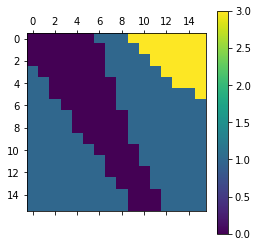

In [27]:
im = plt.matshow(policy_matrix)
plt.colorbar(im)